In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [01:48:44] Enabling RDKit 2019.09.3 jupyter extensions
[01:48:44] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

In [3]:
random_seed = 8 # 69, 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 2

number of all smiles:  642
number of successfully processed smiles:  642


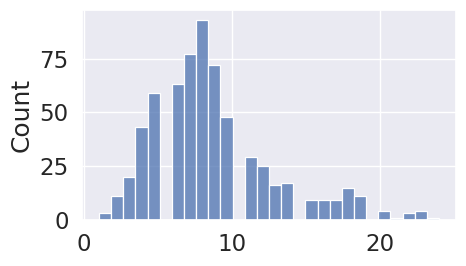

In [4]:
task_name = 'hydration free energy'
tasks = ['expt']

raw_filename = "../data/SAMPL.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

N


S


C


feature dicts file saved as ../data/SAMPL.pickle
not processed items


,iupac,smiles,expt,calc,cano_smiles
61,ammonia,N,-4.29,-4.018,N
195,hydrogen sulfide,S,-0.70,-1.135,S
286,methane,C,2.00,2.446,C


In [6]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(len(test_df),sorted(test_df.cano_smiles.values))


In [7]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [8]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [9]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':valid_MAE, 'test_MAE':valid_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':valid_MAE, 'test_MSE':valid_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.8:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >18):        
        break
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    train(model, train_df, optimizer, loss_function)


0 5.4942656 4.634514
1 3.4563665 3.3737502


2 3.410076 3.1560116
3 3.328856 3.1758907


4 3.239614 2.9395883
5 3.0984497 2.8964367


6 2.862649 2.5856202
7 2.590604 2.393841


8 2.3064446 2.024831
9 2.132677 1.8964455


10 2.0228002 1.90194
11 1.9482208 1.9136952


12 1.6623942 1.6566103
13 1.7723492 1.7325048


14 1.5802578 1.5873672
15 1.54717 1.5105535


16 1.355519 1.3400042
17 1.5010763 1.5312936


18 1.5131285 1.2472799
19 1.364387 1.3671367


20 1.2976272 1.2589622
21 1.1990979 1.143247


22 1.1202409 1.0365604
23 1.0652635 1.0581452


24 1.0127882 0.94462454
25 1.0038946 0.9586987


26 1.0212483 0.96772677
27 0.97091556 0.92516303


28 0.9550947 0.8671912
29 0.9380545 0.9331562


30 0.9093254 0.88630325
31 0.9231004 0.89176774


32 0.89592206 0.86803514
33 0.90088785 0.87463063


34 0.92583126 0.8238272
35 0.87554556 0.86898565


36 0.88034683 0.8626605
37 0.9027301 0.9063742


38 0.91404456 0.86374235
39 0.82279336 0.7785108


40 0.8296994 0.81534857
41 0.81816757 0.8313667


42 0.86158735 0.7915134


43 0.9373337 0.9211679
44 0.8663851 0.8468038


45 0.8547497 0.8718827
46 0.87629133 0.8237298


47 0.81967187 0.85809267
48 0.7473748 0.72823095


49 0.72963625 0.7115986
50 0.71275795 0.72474647


51 0.7050772 0.7300975
52 0.7032047 0.7292705


53 0.71057415 0.7386749
54 0.71666723 0.7596034


55 0.69145364 0.7287507
56 0.71636426 0.7572271


57 0.6615161 0.70439035
58 0.6595896 0.7173911


59 0.6540985 0.70764226
60 0.6367555 0.6902705


61 0.6368276 0.7059813
62 0.62512976 0.7189441


63 0.61231667 0.7039194
64 0.617803 0.70452124


65 0.6314114 0.72762764
66 0.596624 0.70131195


67 0.5757662 0.69960296
68 0.5752535 0.68872076


69 0.6616869 0.7629171
70 0.5533634 0.7099721


71 0.5908698 0.74255824
72 0.5760459 0.7222746


73 0.5431153 0.7037157
74 0.53216755 0.69173527


75 0.5778955 0.7427917
76 0.5771741 0.76888424


77 0.5153927 0.7339912
78 0.5967225 0.75769925


79 0.5274105 0.75611395
80 0.52588856 0.79140925


81 0.50792384 0.70503634
82 0.5074354 0.6740833


83 0.531814 0.73324704
84 0.6415837 0.83388376


85 0.6223692 0.7995864
86 0.5141736 0.7089322


87 0.5123425 0.74837834
88 0.5612272 0.73078066


89 0.57298684 0.713264
90 0.5006913 0.6800314


91 0.48053697 0.7106854
92 0.4582666 0.68970275


93 0.4587015 0.6790284
94 0.44818717 0.70703286


95 0.4358188 0.6954731
96 0.4310176 0.665324


97 0.42559972 0.6872278
98 0.40012458 0.72205776


99 0.39188486 0.6978487
100 0.37823647 0.68642867


101 0.39411676 0.65669024
102 0.43080103 0.66289425


103 0.4238759 0.6556775
104 0.40658373 0.6990259


105 0.45204133 0.7098943
106 0.45689967 0.6710905


107 0.39072573 0.6750797
108 0.3918551 0.6742979


109 0.3987202 0.6855007
110 0.38730812 0.66188806


111 0.37715152 0.6414182
112 0.37640476 0.671939


113 0.3501048 0.6331628
114 0.35005188 0.6357366


115 0.34950662 0.63504463
116 0.34707096 0.66528994


117 0.32120392 0.62673795
118 0.34266123 0.6876897


119 0.33769014 0.6969008
120 0.35630867 0.692257


121 0.32490015 0.6448292
122 0.30451623 0.6693551


123 0.32309526 0.7316622
124 0.28882328 0.6336438


125 0.30742326 0.62690526
126 0.39496088 0.7352191


127 0.290826 0.67463154
128 0.3564882 0.70808107


129 0.30413505 0.6588403
130 0.41740885 0.69306844


131 0.38254693 0.7193362
132 0.28337726 0.6165089


133 0.30772513 0.6153681


134 0.29388925 0.6171687
135 0.32917053 0.6314439


136 0.27761555 0.63791406
137 0.30257568 0.652048


138 0.2823644 0.6540378
139 0.3556977 0.70968956


140 0.2677126 0.6257405
141 0.31784713 0.6137367


142 0.35641646 0.6711983
143 0.4005297 0.65396994


144 0.2979338 0.6642963
145 0.26548854 0.6933732


146 0.3536392 0.654373
147 0.36823434 0.6713766


148 0.32822907 0.6717684
149 0.3086814 0.73700225


150 0.27336574 0.6536326
151 0.25453135 0.65463924


152 0.30208626 0.7138157
153 0.2934747 0.635526


154 0.28035823 0.65152687
155 0.24132934 0.6495777


156 0.28623176 0.63118416
157 0.2869784 0.6285682


158 0.2807005 0.58664
159 0.30030483 0.6635112


160 0.27229005 0.63068956
161 0.25707272 0.6541517


162 0.23974034 0.6583053
163 0.2927056 0.6458622


164 0.27669355 0.6295532
165 0.3242434 0.5717383


166 0.2646287 0.59495103
167 0.28499892 0.64656836


168 0.34620163 0.664368
169 0.2507619 0.63978285


170 0.25184518 0.6098884
171 0.23173171 0.59641486


172 0.257165 0.6188017
173 0.26570982 0.63030016


174 0.24353084 0.6397609
175 0.2183353 0.62312436


176 0.2503382 0.6147783
177 0.21919052 0.613276


178 0.21938452 0.61632216
179 0.23137467 0.61626846


180 0.2536888 0.61655396
181 0.23755428 0.6194865


182 0.24113859 0.5825038
183 0.21155095 0.6155072


184 0.24013163 0.6072828
185 0.21977068 0.5852533


186 0.23046637 0.62085444
187 0.24481215 0.61137694


188 0.24088863 0.603727
189 0.2208845 0.571531


190 0.23196319 0.5913787
191 0.26062146 0.63316625


192 0.23007643 0.5997785
193 0.22680172 0.6097282


194 0.24680056 0.6046781
195 0.22952399 0.62280107


196 0.21725373 0.6337442
197 0.23107128 0.59268683


198 0.24899998 0.6088294
199 0.22328824 0.59478426


200 0.26822054 0.5949304
201 0.29577702 0.62031925


202 0.28458536 0.61048275
203 0.25245234 0.6187328


204 0.27277163 0.6339533
205 0.28317797 0.6159774


206 0.28584725 0.6441967
207 0.2838806 0.61189204


In [10]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 189 
 test RMSE: 0.7489382
